In [ ]:
## PHASE 1: TRAIN A CLASSIFIER TO IDENTIFY 'SPAM' EMAILS
# 1 - EXPLORATORY DATA ANALYSIS (EDA)
# Download necessary NLTK data and other packages
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
!pip install -q transformers rapidfuzz tqdm

# Importing all packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords as nltk_stopwords
stop_words = set(nltk_stopwords.words('english'))
from wordcloud import WordCloud, STOPWORDS
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.over_sampling import RandomOverSampler
from scipy.stats import uniform, entropy, randint
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
from math import log2
from transformers import pipeline
from collections import Counter, defaultdict
from rapidfuzz import process, fuzz
from tqdm.auto import tqdm
import networkx as nx
sns.set_theme(style="whitegrid")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 60.6 MB/s eta 0:00:00


In [ ]:
# Direct loading from URL
url = 'https://raw.githubusercontent.com/ProfAI/natural-language-processing/refs/heads/main/datasets/Verifica%20Finale%20-%20Spam%20Detection/spam_dataset.csv'
df = pd.read_csv(url)

# Display the first few rows of the dataset
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\nthis deal is to ...,0


##**Project Overview:**
ProfessionAI is developing an AI-powered system to analyze and classify incoming emails, with a strong focus on detecting SPAM. The goal is to improve email security, enhance spam filtering, and extract useful insights from both spam and legitimate emails.

##**Project Objectives:**
- Train a classifier to detect SPAM emails;
- Identify main topics within SPAM content;
- Measure the semantic distance between SPAM topics to assess content diversity;
- Extract organizations mentioned in legitimate (HAM) emails.

##**Dataset Description:**
The dataset used includes 5,171 emails, each labeled as "ham" (legitimate) or "spam" (unwanted). It contains the following columns:
- Unnamed: 0: Unnecessary index column — can be dropped;
- label: Text label indicating email type ("ham" or "spam");
- text: Full email content (subject + body). Main feature for analysis;
- label_num: Numeric version of the label (0 = ham, 1 = spam).

The dataset is clean, with no missing or duplicate data, and is well-suited for text classification, topic modeling, and semantic analysis.

##**Why This Dataset?**
This dataset provides exactly what's needed to achieve the project goals: labeled email texts for spam classification, semantic exploration, and named entity extraction. Its structure makes it ideal for building and evaluating NLP-based solutions efficiently.

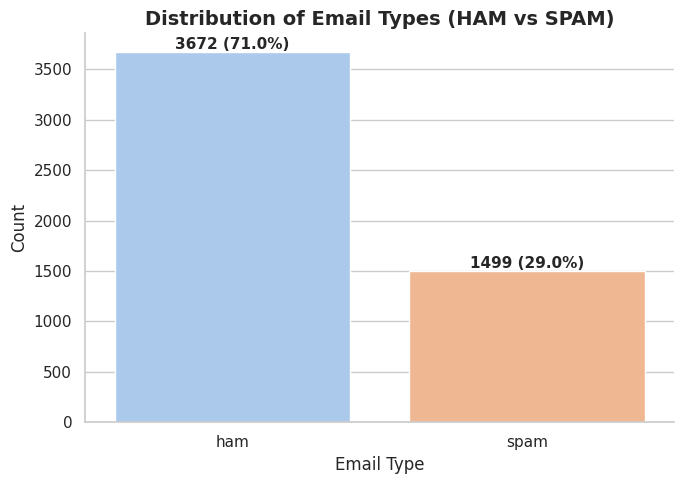

In [ ]:
# Total number of emails for percentage calculation
total = len(df)

# Seaborn style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(7, 5))

# Plot count with hue (future-proof)
ax = sns.countplot(data=df, x='label', hue='label', palette='pastel', legend=False)

# Title and labels
plt.title('Distribution of Email Types (HAM vs SPAM)', fontsize=14, fontweight='bold')
plt.xlabel('Email Type', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Annotate bar values with count and percentage
for p in ax.patches:
    count = int(p.get_height())
    percentage = (count / total) * 100
    ax.annotate(f'{count} ({percentage:.1f}%)',
                (p.get_x() + p.get_width() / 2., count),
                ha='center', va='bottom',
                fontsize=11, fontweight='bold')

# Remove top/right spines
sns.despine()
plt.tight_layout()
plt.show()

##**Distribution of Email Types (HAM vs SPAM):**
This visualization displays the distribution of email types within the dataset — specifically the number of emails labeled as HAM (legitimate) versus SPAM (unwanted).

The bar plot shows a clear class imbalance:

- HAM emails make up 3,672 of the total, which is about 71% of the dataset;

- SPAM emails account for 1,499, or around 29%.

This imbalance is important to highlight because it may affect the performance of machine learning models, especially in classification tasks. Models trained on imbalanced datasets tend to be biased toward the majority class (in this case, HAM), potentially leading to poor detection of the minority class (SPAM).

The inclusion of both absolute counts and percentages above each bar helps communicate the scale of the data clearly, aiding in decisions about potential preprocessing steps such as resampling or class weighting to handle the imbalance.

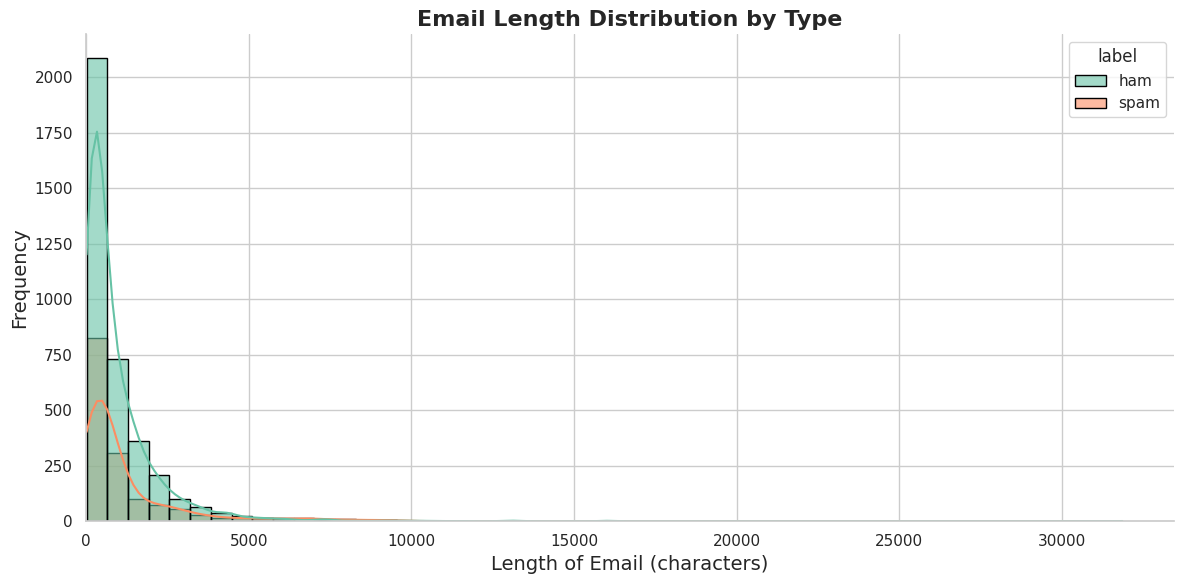

In [ ]:
# If your text column is named 'text', create the text_length column
df['text_length'] = df['text'].apply(len)

# Set Seaborn style for a clean white grid background
sns.set_theme(style="whitegrid")

# Create a figure with a larger size for better readability
plt.figure(figsize=(12, 6))

# Plot histogram with KDE (Kernel Density Estimate) by email label (ham or spam)
ax = sns.histplot(
    data=df,               # Data source
    x='text_length',       # Variable on x-axis (email length)
    hue='label',           # Color by 'label' column (spam or ham)
    bins=50,               # Number of bins in histogram
    kde=True,              # Overlay Kernel Density Estimate curve
    palette='Set2',        # Color palette for different labels
    alpha=0.6,             # Transparency of histogram bars
    edgecolor='black'      # Black border around histogram bars for clarity
)

# Set the plot title with larger, bold font (emoji removed to avoid font warnings)
plt.title('Email Length Distribution by Type', fontsize=16, fontweight='bold')

# Label x-axis
plt.xlabel('Length of Email (characters)', fontsize=14)

# Label y-axis
plt.ylabel('Frequency', fontsize=14)

# Set x-axis and y-axis limits to start at zero
plt.xlim(left=0)
plt.ylim(bottom=0)

# Remove top and right plot borders for a cleaner look
sns.despine()

# Automatically adjust subplot params to give padding and prevent clipping
plt.tight_layout()

# Show the plot
plt.show()

##**Email Length Distribution by Type:**
This visualization shows the distribution of email lengths (measured in number of characters) for both HAM and SPAM emails in the dataset.

Using a histogram overlaid with Kernel Density Estimation (KDE), the plot reveals how the two classes differ in terms of textual length:

- HAM emails tend to have longer and more variable lengths, with a smoother distribution and a longer tail;

- SPAM emails are generally shorter and more concentrated within a narrower range of lengths.

The x-axis represents the length of each email, while the y-axis shows the frequency of emails within specific length ranges. Both axes start at zero to provide an accurate and unbiased view of the distribution.

By comparing these distributions, we gain insights that could inform feature engineering or model design. For example, email length could be used as a distinguishing feature for classification, since SPAM and HAM exhibit different length patterns. This also helps to visually understand behavioral differences between legitimate and spam messages.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


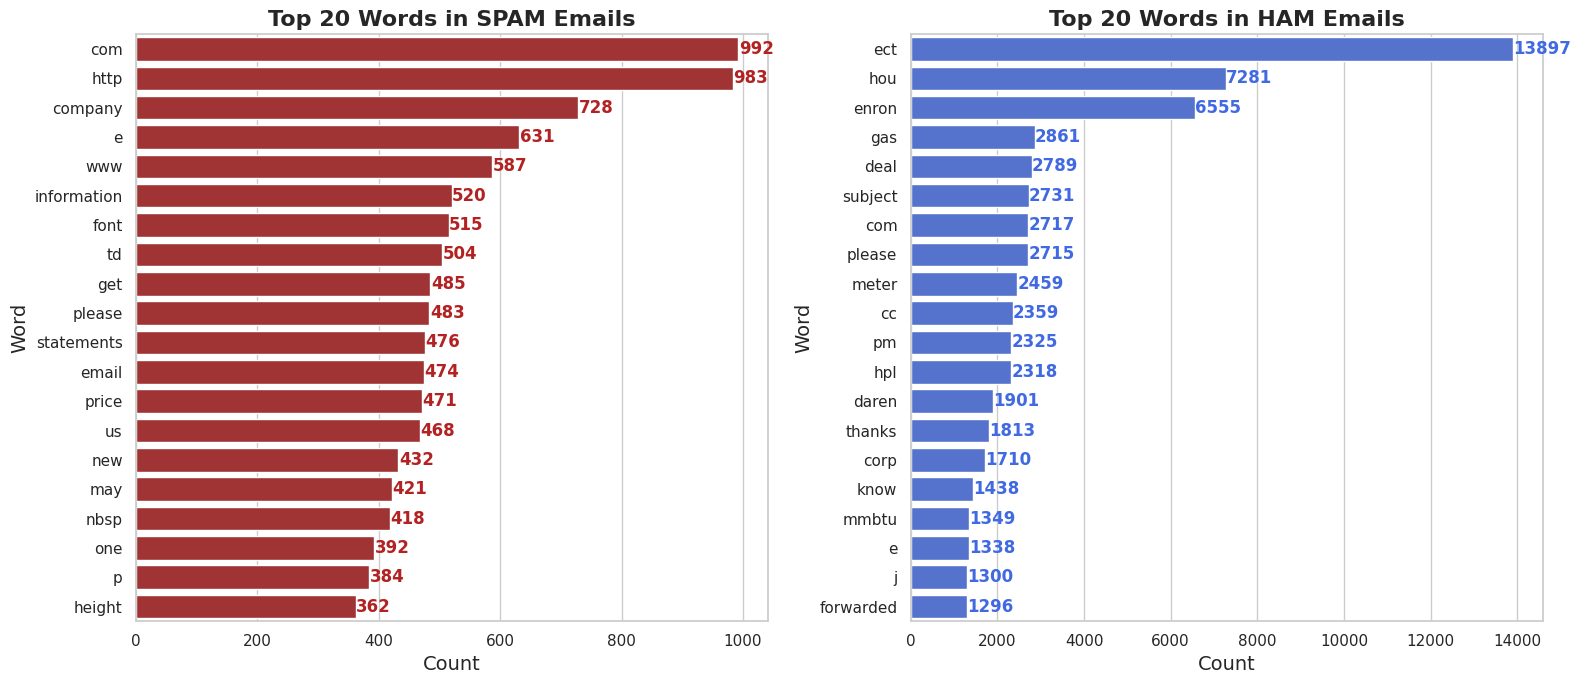

In [ ]:
# Reload packages
import nltk
from nltk.corpus import stopwords
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
nltk.download('stopwords')

# Function to get most common words from a text corpus
def get_top_n_words(corpus, n=20):
    stop_words = set(stopwords.words('english'))
    # Join all text, lowercase, split into words
    words = " ".join(corpus).lower().split()
    # Filter out non-alphabetic words and stopwords
    filtered_words = [word for word in words if word.isalpha() and word not in stop_words]
    # Count and return most common n words
    return Counter(filtered_words).most_common(n)

# Get top 20 words in SPAM and HAM emails
spam_words = get_top_n_words(df[df['label'] == 'spam']['text'])
ham_words = get_top_n_words(df[df['label'] == 'ham']['text'])

# Convert to DataFrame for plotting
spam_df = pd.DataFrame(spam_words, columns=['word', 'count'])
ham_df = pd.DataFrame(ham_words, columns=['word', 'count'])

# Set seaborn style for clean plots
sns.set_theme(style="whitegrid")

# Create subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot top spam words with red color
sns.barplot(data=spam_df, x='count', y='word', ax=axes[0], color='firebrick')
axes[0].set_title('Top 20 Words in SPAM Emails', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Count', fontsize=14)
axes[0].set_ylabel('Word', fontsize=14)

# Annotate bars with counts on the right
for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_width())}',
                     (p.get_width() + 1, p.get_y() + p.get_height() / 2),
                     va='center', fontsize=12, fontweight='bold', color='firebrick')

# Plot top ham words with blue color
sns.barplot(data=ham_df, x='count', y='word', ax=axes[1], color='royalblue')
axes[1].set_title('Top 20 Words in HAM Emails', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Count', fontsize=14)
axes[1].set_ylabel('Word', fontsize=14)

# Annotate bars with counts on the right
for p in axes[1].patches:
    axes[1].annotate(f'{int(p.get_width())}',
                     (p.get_width() + 1, p.get_y() + p.get_height() / 2),
                     va='center', fontsize=12, fontweight='bold', color='royalblue')

plt.tight_layout()
plt.show()

##**Top 20 Words in SPAM Emails vs Top 20 Words in HAM Emails:**
This visualization presents a comparative analysis of the most frequent words used in SPAM and HAM (non-spam) emails.

Each subplot shows the top 20 most common words (excluding English stopwords and non-alphabetic terms) for the respective category:

- On the left, the bar chart displays the most frequent words found in SPAM emails, using a red color scheme;

- On the right, the bar chart shows the top words in HAM emails, using a blue color scheme.

Each bar represents the frequency count of a specific word, and the value is also annotated next to each bar for clarity.

This analysis helps highlight the lexical differences between spam and legitimate messages. For instance:

- SPAM emails often include words related to offers, marketing, or urgency, such as "free", "win", "cash", etc;

- HAM emails are more likely to contain common conversational or informative terms that reflect natural, human communication.

These insights are valuable for:

- Feature engineering -> Frequent words can be used as inputs for classification models;

- Understanding intent -> Revealing thematic or behavioral patterns in SPAM;

- Building better filters -> Identifying word patterns that are strong indicators of spam-like content.

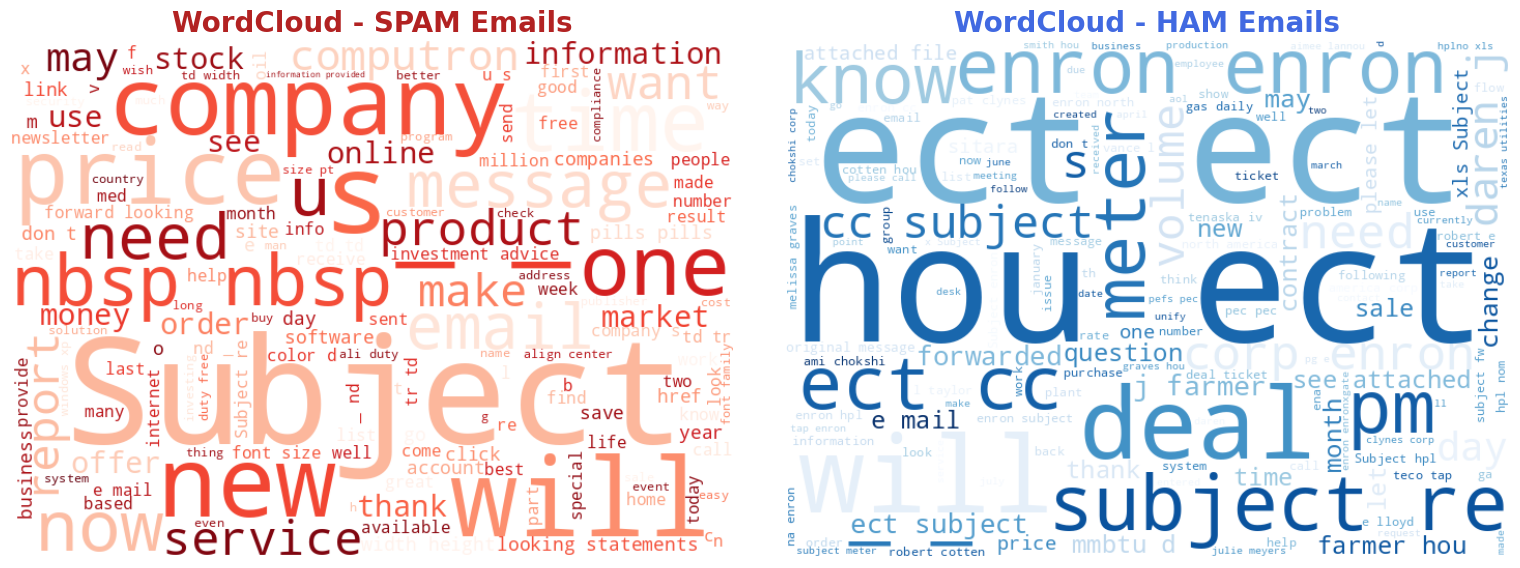

In [ ]:
# Combine all SPAM email texts into one string
spam_text = " ".join(df[df['label'] == 'spam']['text'].values)

# Combine all HAM email texts into one string
ham_text = " ".join(df[df['label'] == 'ham']['text'].values)

# Define common stopwords to exclude from wordclouds for cleaner visuals
stopwords = set(STOPWORDS)

# Set up the figure with a larger size for better visibility
plt.figure(figsize=(16, 8))

# SPAM WordCloud
plt.subplot(1, 2, 1)
wordcloud_spam = WordCloud(
    width=700,                # Width of the canvas
    height=500,               # Height of the canvas
    background_color='white', # Background color
    stopwords=stopwords,      # Stopwords to exclude common words
    max_words=150,            # Max number of words to show
    contour_color='firebrick',# Outline color of wordcloud
    contour_width=1.5,        # Outline thickness
    colormap='Reds'           # Color palette for SPAM
).generate(spam_text)
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.title("WordCloud - SPAM Emails", fontsize=20, fontweight='bold', color='firebrick')
plt.axis('off')

# HAM WordCloud
plt.subplot(1, 2, 2)
wordcloud_ham = WordCloud(
    width=700,
    height=500,
    background_color='white',
    stopwords=stopwords,
    max_words=150,
    contour_color='royalblue',
    contour_width=1.5,
    colormap='Blues'
).generate(ham_text)
plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.title("WordCloud - HAM Emails", fontsize=20, fontweight='bold', color='royalblue')
plt.axis('off')

# Adjust layout so titles and images don't overlap
plt.tight_layout(pad=3)

# Show the wordcloud plots
plt.show()

##**WordCloud - SPAM Emails vs WordCloud - HAM Emails:**
This visualization displays two word clouds that illustrate the most frequently used words in the email dataset, separated by category:

- On the left, the word cloud shows the most common words found in SPAM emails;

- On the right, the word cloud shows the most common words found in HAM (non-spam) emails.

Each word’s size reflects its frequency in the corresponding email type — the larger the word, the more often it appears. Common English stopwords (e.g., "the", "and", "is") have been excluded to improve clarity and focus on meaningful terms.

The color schemes help differentiate the two types:

- SPAM words are shown in red tones with a firebrick outline, emphasizing urgency and danger;

- HAM words are shown in blue tones with a royal blue outline, representing trust and normalcy.

This visual comparison helps:

- Identify key spam-related terms, such as promotional or deceptive language;

- Understand natural vocabulary patterns in legitimate communications;

- Support feature selection for classification models by revealing high-frequency content words.

Overall, the word clouds offer an intuitive and visually engaging way to grasp the lexical patterns and thematic contrasts between spam and ham emails.

In [ ]:
# 2 - DATA CLEANING & PREPROCESSING
# Define lemmatizer
lemmatizer = WordNetLemmatizer()

# Advanced cleaning function
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Replace URLs with token
    text = re.sub(r'http\S+|www\S+|https\S+', ' URL ', text)
    # Remove emails
    text = re.sub(r'\S+@\S+', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove punctuation/special chars
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords + Lemmatization
    tokens = [lemmatizer.lemmatize(tok) for tok in tokens if tok not in stop_words]
    return ' '.join(tokens)

# Apply cleaning
df['clean_text'] = df['text'].apply(clean_text)

##**2 - DATA CLEANING & PREPROCESSING:**
This preprocessing function is designed to prepare raw text data for natural language processing tasks by cleaning and normalizing it.

1. Lowercasing – All characters are converted to lowercase to ensure consistency and avoid treating words differently due to capitalization.

2. Noise reduction –

   - URLs are not removed but replaced with the token "URL" so they remain informative while being standardized;
   
   - Email addresses, numbers, punctuation, and other special characters are removed to eliminate irrelevant noise;
   
   - The text is then tokenized into individual words for further processing.

3. Stopword removal & lemmatization – Common stopwords (e.g., “the”, “and”, “is”) are filtered out to focus on semantically meaningful terms. Remaining tokens are lemmatized to their base forms (e.g., “running” → “run”), reducing word variation and dimensionality.

4. Reassembly – The cleaned tokens are joined back into a single string for each text entry, producing standardized and informative text.

This process ensures that important patterns (like the presence of links) are preserved while removing irrelevant noise, ultimately improving the quality and effectiveness of downstream models such as classifiers or topic models.

In [ ]:
# 3 - FEATURE EXTRACTION (TF-IDF)
vectorizer = TfidfVectorizer(
    max_features=5000,   # Limit to top 5000 features to control dimensionality
    ngram_range=(1,2),   # Include both unigrams and bigrams for richer representation
    min_df=2,            # Ignore terms that appear in fewer than 2 documents (too rare)
    max_df=0.85           # Ignore terms that appear in more than 85% of documents (too common)
)
X = vectorizer.fit_transform(df['clean_text']) # Convert cleaned text into TF-IDF feature matrix
y = df['label_num']  # Extract labels: 0 for ham, 1 for spam

##**3 - FEATURE EXTRACTION (TF-IDF):**
This block performs feature extraction by converting the cleaned email text into a numerical matrix suitable for machine learning models.

- Uses TF-IDF (Term Frequency–Inverse Document Frequency) to:

  - Count word occurrences;

  - Downweight very common words that carry little information.

- Includes both:

  - Unigrams → single words;

  - Bigrams → pairs of consecutive words.

- Limits the vocabulary to the top 5,000 most relevant features to:

  - Reduce noise;

  - Lower computational cost.

- Filters terms to improve feature quality:

  - Excludes terms appearing in fewer than 2 documents (too rare);

  - Excludes terms present in over 85% of documents (too frequent).

- Target labels extracted from the dataset’s label column:

  - 0 → non-spam (ham) emails;

  - 1 → spam emails.

In [ ]:
# 4 - TRAIN-TEST SPLIT + RANDOM OVERSAMPLING
# Stratified split to maintain label ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Management of class imbalance through oversampling
oversampler = RandomOverSampler(random_state=42)
X_train_res, y_train_res = oversampler.fit_resample(X_train, y_train)

##**4 - TRAIN-TEST SPLIT + RANDOM OVERSAMPLING:**
- Split data into training and testing sets.

- Stratification ensures the spam/ham ratio stays consistent in both sets.

- Random oversampling applied only to training data:

  - Duplicates spam emails (minority class);

  - Balances class distribution.
  
- Prevents test set leakage and improves spam detection.

In [ ]:
# 5.a - MODEL TRAINING WITH RANDOM SEARCH (LOGISTIC REGRESSION)
# Define the hyperparameter search space for Logistic Regression
param_dist_lr = {
    'C': uniform(loc=0.001, scale=1),  # Continuous range for regularization strength
    'penalty': ['elasticnet'],         # Use ElasticNet regularization
    'l1_ratio': uniform(0, 1),         # Balance between L1 and L2 regularization
    'solver': ['saga']                 # Solver compatible with ElasticNet
}

# Initialize Logistic Regression model with balanced class weights
lr = LogisticRegression(
    class_weight='balanced',  # Adjust weights to handle class imbalance
    max_iter=300,             # Maximum iterations for convergence
    random_state=42           # Set seed for reproducibility
)

# Setup RandomizedSearchCV to find best hyperparameters using 5-fold cross-validation
random_search_lr = RandomizedSearchCV(
    estimator=lr,                       # Logistic regression estimator
    param_distributions=param_dist_lr,  # Hyperparameter search space
    n_iter=20,                          # Number of random parameter combinations to try
    cv=5,                               # 5-fold cross-validation
    scoring='f1_macro',                 # Optimize macro F1 score for balanced class performance
    random_state=42,                    # Set seed for reproducibility
    n_jobs=-1                           # Use all CPU cores for parallel processing
)

# Fit RandomizedSearchCV on the oversampled training data
random_search_lr.fit(X_train_res, y_train_res)

# Extract the best model after hyperparameter tuning
best_model_lr = random_search_lr.best_estimator_

# Print the best alpha value found
print(f"Best Logistic Regression Hyperparameters: {random_search_lr.best_params_}")

Best Logistic Regression Hyperparameters: {'C': np.float64(0.5934145688620425), 'l1_ratio': np.float64(0.046450412719997725), 'penalty': 'elasticnet', 'solver': 'saga'}


##**5.a - MODEL TRAINING WITH RANDOM SEARCH (LOGISTIC REGRESSION):**
- Model: Logistic Regression with balanced class weights (handles imbalance).

- Search space:

  - Regularization strength (C);

  - Penalty type;

  - L1 Ratio;

  - Solver algorithm.

- Setup:

  - Increased iteration limit for stable convergence;

  - RandomizedSearchCV → 20 random parameter combos;

  - 5-fold cross-validation;

  - Optimized for macro F1 score (balanced performance on both classes).

- Output: Best model selected & hyperparameters printed for final evaluation.

In [ ]:
# 6.a - MODEL EVALUATION (LOGISTIC REGRESSION)
# Predict on training and test sets
y_train_pred_lr = best_model_lr.predict(X_train)
y_test_pred_lr = best_model_lr.predict(X_test)

# Evaluation metrics for training set
print("=== TRAINING SET PERFORMANCE ===")
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred_lr))
print("\nClassification Report:\n", classification_report(y_train, y_train_pred_lr, target_names=['HAM', 'SPAM']))

# Evaluation metrics for test set
print("\n=== TEST SET PERFORMANCE ===")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred_lr, target_names=['HAM', 'SPAM']))

=== TRAINING SET PERFORMANCE ===
Confusion Matrix:
 [[2851   86]
 [   1 1198]]

Classification Report:
               precision    recall  f1-score   support

         HAM       1.00      0.97      0.98      2937
        SPAM       0.93      1.00      0.96      1199

    accuracy                           0.98      4136
   macro avg       0.97      0.98      0.97      4136
weighted avg       0.98      0.98      0.98      4136


=== TEST SET PERFORMANCE ===
Confusion Matrix:
 [[698  37]
 [  0 300]]

Classification Report:
               precision    recall  f1-score   support

         HAM       1.00      0.95      0.97       735
        SPAM       0.89      1.00      0.94       300

    accuracy                           0.96      1035
   macro avg       0.95      0.97      0.96      1035
weighted avg       0.97      0.96      0.96      1035



##**6.a - MODEL EVALUATION (LOGISTIC REGRESSION):**
This code block evaluates the performance of the best Logistic Regression model on the test dataset by:

- Predicting labels for the test features.

- Calculating evaluation metrics:

  - Confusion Matrix – counts of:

     - True Positives (TP);

     - True Negatives (TN);

     - False Positives (FP);

     - False Negatives (FN);

     - Helps understand the types of classification errors.

  - Classification Report – detailed metrics for each class (HAM and SPAM_Precision):

     - Precision;

     - Recall;

     - F1-score;
     
     - Overall accuracy and averaged scores.

Comments on the results:

- The confusion matrix shows a small number of errors: 86 HAM emails were incorrectly classified as SPAM in the training set, and 37 HAM emails were mislabeled as SPAM in the test set. No SPAM emails were missed in the test set;

- Precision for HAM is perfect on the test set (1.00), meaning all predicted HAM emails were truly HAM. SPAM precision is slightly lower (0.89), indicating that some HAM emails were mistakenly flagged as SPAM (false positives);

- Recall remains very high for both classes (HAM: 0.95, SPAM: 1.00), showing the model captures almost all real emails in each category, with SPAM being detected flawlessly;

- The F1-scores (HAM: 0.97, SPAM: 0.94) confirm a solid trade-off between precision and recall, with only a slight drop for SPAM due to false positives;

- Overall accuracy reaches 96%, confirming that the model correctly classifies the vast majority of emails;

- Macro and weighted averages (0.96–0.97) indicate balanced performance across classes, proving the model handles the HAM-SPAM distinction consistently well.

In summary, the Logistic Regression model achieves excellent results, with particularly strong SPAM detection (perfect recall) and only a modest number of false positives on HAM. The slight gap between training (98%) and test (96%) accuracy suggests minimal overfitting, while overall predictive quality remains very high.

In [ ]:
# 5.b - MODEL TRAINING WITH RANDOM SEARCH (MULTINOMIAL NAIVE BAYES)
# Initialize Multinomial Naive Bayes
nb = MultinomialNB()

# Define hyperparameter search space for alpha
param_dist_nb = {
    'alpha': uniform(loc=0.0, scale=1.0)  # Continuous range between 0.0 and 1.0
}

# Setup RandomizedSearchCV for Naive Bayes
random_search_nb = RandomizedSearchCV(
    estimator=nb,                            # Naive Bayes estimator
    param_distributions=param_dist_nb,       # Hyperparameter search space
    n_iter=20,                               # Number of random combinations to try
    cv=5,                                    # 5-fold cross-validation
    scoring='f1_macro',                      # Optimize macro F1 score for balanced class performance
    random_state=42,                         # Set seed for reproducibility
    n_jobs=-1,                               # Use all available CPU cores
    verbose=1                                # Print progress during fitting
)

# Print progress during fitting
random_search_nb.fit(X_train_res, y_train_res)

# Extract the best model after hyperparameter tuning
best_model_nb = random_search_nb.best_estimator_

# Print the best alpha value found
print("Best Naive Bayes Hyperparameters:", random_search_nb.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Naive Bayes Hyperparameters: {'alpha': np.float64(0.020584494295802447)}


##**5.b - MODEL TRAINING WITH RANDOM SEARCH (MULTINOMIAL NAIVE BAYES):**

- Model: Multinomial Naive Bayes (suitable for text classification with count/TF-IDF features).

- Search space:

  - Additive smoothing parameter (alpha) in the range [0.0, 1.0].

- Setup:

  - RandomizedSearchCV → 20 random parameter combinations;

  - 5-fold cross-validation for robust evaluation;

  - Optimized for macro F1 score (ensures balanced performance across HAM and SPAM);

  - Parallel execution on all CPU cores (n_jobs=-1).

- Output:
  
  - Best Naive Bayes model selected;
  
  - Best alpha value printed for final evaluation.

In [ ]:
# 6.b - MODEL EVALUATION (MULTINOMIAL NAIVE BAYES)
# Predictions on training and test sets
y_train_pred_nb = best_model_nb.predict(X_train)
y_test_pred_nb = best_model_nb.predict(X_test)

# Training set performance
print("=== TRAINING SET PERFORMANCE ===")
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred_nb))
print("\nClassification Report:\n", classification_report(y_train, y_train_pred_nb, target_names=['HAM', 'SPAM']))

# Test set performance
print("\n=== TEST SET PERFORMANCE ===")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_nb))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred_nb, target_names=['HAM', 'SPAM']))

=== TRAINING SET PERFORMANCE ===
Confusion Matrix:
 [[2821  116]
 [  23 1176]]

Classification Report:
               precision    recall  f1-score   support

         HAM       0.99      0.96      0.98      2937
        SPAM       0.91      0.98      0.94      1199

    accuracy                           0.97      4136
   macro avg       0.95      0.97      0.96      4136
weighted avg       0.97      0.97      0.97      4136


=== TEST SET PERFORMANCE ===
Confusion Matrix:
 [[691  44]
 [  9 291]]

Classification Report:
               precision    recall  f1-score   support

         HAM       0.99      0.94      0.96       735
        SPAM       0.87      0.97      0.92       300

    accuracy                           0.95      1035
   macro avg       0.93      0.96      0.94      1035
weighted avg       0.95      0.95      0.95      1035



##**6.b - MODEL EVALUATION (MULTINOMIAL NAIVE BAYES):**

- Training Set:

  - Confusion matrix shows 116 HAM emails incorrectly flagged as SPAM and 23 SPAM emails mislabeled as HAM;

  - HAM: Precision is 0.99, Recall 0.96 → almost perfect, with a small number of missed HAM;

  - SPAM: Precision 0.91, Recall 0.98 → the model identifies almost all SPAM, but sometimes misclassifies HAM as SPAM (false positives);

  - Accuracy is 0.97, with macro and weighted F1 scores around 0.96–0.97, showing strong overall balance.

- Test Set:

  - Confusion matrix shows 44 HAM emails mislabeled as SPAM and 9 SPAM emails mislabeled as HAM;

  - HAM: Precision 0.99, Recall 0.94 → excellent precision, but some HAM emails are misclassified as SPAM;

  - SPAM: Precision 0.87, Recall 0.97 → strong recall (few SPAM missed), but lower precision indicates the model is a bit more prone to false positives;

  - Accuracy is 0.95, with macro F1 at 0.94, confirming robust but slightly less balanced performance compared to Logistic Regression.

In summary, the Multinomial Naive Bayes model performs very well overall, with excellent recall for SPAM (0.97) on the test set, meaning it successfully captures nearly all unwanted emails. The main weakness lies in precision for SPAM (0.87), where some HAM messages are incorrectly flagged. Compared to Logistic Regression, Naive Bayes shows slightly more false positives on HAM, but maintains strong overall accuracy (95%) and a good trade-off between recall and precision.

In [ ]:
# 5.c - MODEL TRAINING WITH RANDOM SEARCH (MLP)
# Define the hyperparameter search space for the MLP
param_dist_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50,50)],  # Different small network architectures for faster training
    'activation': ['relu', 'tanh'],                  # Activation functions to try
    'alpha': uniform(0.001, 0.05),                   # L2 regularization (slightly stronger to reduce overfitting)
    'learning_rate_init': uniform(0.001, 0.01),      # Initial learning rate for gradient descent
    'max_iter': [300],                               # Maximum iterations for training
    'early_stopping': [True],                        # Enable early stopping based on validation loss
    'n_iter_no_change': [15, 20]                     # Number of iterations to wait for improvement before stopping
}

# Initialize base MLP
mlp = MLPClassifier(random_state=42)

# Setup RandomizedSearchCV
random_search_mlp = RandomizedSearchCV(
    estimator=mlp,                       # MLP classifier
    param_distributions=param_dist_mlp,  # Hyperparameter search space
    n_iter=10,                           # Number of random combinations to try (fewer for faster prototyping)
    cv=3,                                # 3-fold cross-validation
    scoring='f1_macro',                  # Optimize macro F1 score for balanced class performance
    n_jobs=-1,                           # Use all available CPU cores
    random_state=42                      # Set seed for reproducibility
)

# Fit RandomizedSearchCV on the oversampled training dataset
random_search_mlp.fit(X_train_res, y_train_res)

# Extract the best model after hyperparameter tuning
best_model_mlp = random_search_mlp.best_estimator_

# Print the best combination of hyperparameters found
print("Best MLP Hyperparameters:", random_search_mlp.best_params_)

Best MLP Hyperparameters: {'activation': 'relu', 'alpha': np.float64(0.015561457009902097), 'early_stopping': True, 'hidden_layer_sizes': (50, 50), 'learning_rate_init': np.float64(0.004998609717152555), 'max_iter': 300, 'n_iter_no_change': 20}


##**5.c - MODEL TRAINING WITH RANDOM SEARCH (MLP):**

- Model: Multi-Layer Perceptron (MLP) classifier, a feed-forward neural network.

- Search space:

  - Hidden layer sizes: small architectures → (50,), (100,), (50,50);

  - Activation functions: ReLU, Tanh;

  - L2 Regularization (alpha): uniform distribution between 0.001 and 0.05;

  - Learning rate initialization: uniform distribution between 0.001 and 0.01;

  - Max iterations: 300;

  - Early stopping enabled (based on validation performance);

  - Patience (n_iter_no_change): 15 or 20 iterations without improvement.

- Setup:

  - RandomizedSearchCV → 10 random parameter combinations for faster prototyping;

  - 3-fold cross-validation to evaluate generalization during tuning:

  - Optimized for macro F1 score (ensures balanced performance between HAM and SPAM);

  - Parallelized with all available CPU cores;

  - Random seed fixed for reproducibility.

- Output:

  - Best neural network configuration is selected after search;

  - Optimal hyperparameters are printed for final evaluation and reuse.

In [ ]:
# 6.c - MODEL EVALUATION (MLP)
# Evaluate on training and test sets
y_train_pred_mlp = best_model_mlp.predict(X_train)
y_test_pred_mlp  = best_model_mlp.predict(X_test)

# Training set performance
print("=== TRAINING SET PERFORMANCE ===")
print(confusion_matrix(y_train, y_train_pred_mlp))
print(classification_report(y_train, y_train_pred_mlp, target_names=['HAM','SPAM']))

# Test set performance
print("=== TEST SET PERFORMANCE ===")
print(confusion_matrix(y_test, y_test_pred_mlp))
print(classification_report(y_test, y_test_pred_mlp, target_names=['HAM','SPAM']))

=== TRAINING SET PERFORMANCE ===
[[2931    6]
 [   2 1197]]
              precision    recall  f1-score   support

         HAM       1.00      1.00      1.00      2937
        SPAM       1.00      1.00      1.00      1199

    accuracy                           1.00      4136
   macro avg       1.00      1.00      1.00      4136
weighted avg       1.00      1.00      1.00      4136

=== TEST SET PERFORMANCE ===
[[723  12]
 [ 13 287]]
              precision    recall  f1-score   support

         HAM       0.98      0.98      0.98       735
        SPAM       0.96      0.96      0.96       300

    accuracy                           0.98      1035
   macro avg       0.97      0.97      0.97      1035
weighted avg       0.98      0.98      0.98      1035



##**6.c - MODEL EVALUATION (MLP):**

- Training Set:

  - Confusion matrix shows only 6 HAM emails mislabeled as SPAM and 2 SPAM emails mislabeled as HAM → essentially perfect separation;

  - HAM: Precision and Recall both at 1.00 → the model recognizes HAM emails without error;

  - SPAM: Precision and Recall also at 1.00 → flawless SPAM detection;

  - Accuracy, macro, and weighted F1 scores are 1.00, indicating the model fits the training data almost perfectly.

- Test Set:

  - Confusion matrix shows 12 HAM emails incorrectly flagged as SPAM and 13 SPAM emails mislabeled as HAM;

  - HAM: Precision 0.98, Recall 0.98 → extremely strong, with only a few HAM misclassified;

  - SPAM: Precision 0.96, Recall 0.96 → very balanced, with minimal false positives and false negatives;

  - Accuracy is 0.98, and both macro and weighted F1 scores reach 0.97–0.98, proving consistent and robust performance.

In summary, the MLP achieves outstanding results, nearly perfect on the training set and maintaining excellent generalization on the test set (98% accuracy). Compared to Logistic Regression and Naive Bayes, the neural network shows the highest overall balance between precision and recall for both HAM and SPAM. The only caution is the perfect training performance, which suggests a mild risk of overfitting — though the test metrics confirm that generalization remains excellent.

In [ ]:
# 6.d - RESULTS COMMENTARY
# Define predictions for each model on both training and test sets
predictions = {
    'Logistic Regression': {'train': y_train_pred_lr, 'test': y_test_pred_lr},
    'Multinomial NB': {'train': y_train_pred_nb, 'test': y_test_pred_nb},
    'MLP': {'train': y_train_pred_mlp, 'test': y_test_pred_mlp}
}

data = []

# Loop through models and splits (train/test)
for model_name, preds in predictions.items():
    for split in ['train', 'test']:
        # Generate classification report (precision, recall, f1, accuracy)
        report = classification_report(
            y_train if split=='train' else y_test,  # Ground truth
            preds[split],                           # Predictions
            target_names=['HAM', 'SPAM'],           # Labels
            output_dict=True                        # Get metrics as dict for programmatic access
        )

        # Collect relevant metrics in a structured dictionary
        data.append({
            'Model': model_name,
            'Split': split,
            'Accuracy': report['accuracy'],
            'Macro Precision': report['macro avg']['precision'],
            'Macro Recall': report['macro avg']['recall'],
            'Macro F1': report['macro avg']['f1-score'],
            'Weighted F1': report['weighted avg']['f1-score'],
            'HAM F1': report['HAM']['f1-score'],
            'SPAM F1': report['SPAM']['f1-score']
        })

# Convert results to DataFrame
comparison_df = pd.DataFrame(data)

# Sort so that each model shows train first, then test
comparison_df = comparison_df.sort_values(by=["Model", "Split"])

# Print results as Markdown table (cleaner formatting for console/markdown reports)
print(comparison_df.to_markdown(index=False))

| Model               | Split   |   Accuracy |   Macro Precision |   Macro Recall |   Macro F1 |   Weighted F1 |   HAM F1 |   SPAM F1 |
|:--------------------|:--------|-----------:|------------------:|---------------:|-----------:|--------------:|---------:|----------:|
| Logistic Regression | test    |   0.964251 |          0.945104 |       0.97483  |   0.958048 |      0.964828 | 0.97418  |  0.941915 |
| Logistic Regression | train   |   0.978965 |          0.966336 |       0.984942 |   0.974967 |      0.979171 | 0.984971 |  0.964962 |
| MLP                 | test    |   0.975845 |          0.971102 |       0.97017  |   0.970634 |      0.975833 | 0.983005 |  0.958264 |
| MLP                 | train   |   0.998066 |          0.997165 |       0.998145 |   0.997653 |      0.998067 | 0.998637 |  0.996669 |
| Multinomial NB      | test    |   0.948792 |          0.9279   |       0.955068 |   0.939801 |      0.949579 | 0.963066 |  0.916535 |
| Multinomial NB      | train   |   0.966393 |  

##**6.d - RESULTS COMMENTARY:**

- Logistic Regression:

  - Train: Accuracy of ~97.9%, with balanced Macro F1 (0.97) and excellent per-class F1 (HAM: 0.98, SPAM: 0.96);

  - Test: Accuracy drops slightly to ~96.4%, with strong Macro F1 (0.96). Recall remains high (0.97), showing the model captures most emails, while SPAM precision (0.94) suggests some HAM emails are still misclassified as SPAM;

  - Overall: Robust and well-generalized, with only a modest gap between training and test performance.

- MLP (Neural Network):

  - Train: Extremely high performance (Accuracy: 99.8%, Macro F1: 0.99+), showing the model fits the data almost perfectly;

  - Test: Maintains strong generalization (Accuracy: 97.6%, Macro F1: 0.97), with balanced scores for HAM (0.98) and SPAM (0.96);

  - Overall: Best performer on the test set, but the near-perfect training accuracy suggests some risk of overfitting, although test metrics remain excellent.

- Multinomial Naive Bayes:

  - Train: Solid performance (Accuracy: 96.6%, Macro F1: 0.96), slightly lower than Logistic Regression and MLP;

  - Test: Accuracy at ~94.9%, Macro F1: 0.94. HAM F1 is strong (0.96), but SPAM F1 drops to 0.91, indicating more false positives (HAM flagged as SPAM);

  - Overall: Simplest model with consistently good results, but weaker than Logistic Regression and MLP, especially in precision for SPAM.

In summary:

- MLP achieves the highest overall performance, but with signs of overfitting;

- Logistic Regression is very stable, with excellent generalization and only slightly behind MLP in accuracy;

- Multinomial Naive Bayes remains a competitive baseline, but is less balanced, especially for SPAM classification.

This comparison highlights how more complex models (MLP) improve accuracy but risk overfitting, while Logistic Regression offers a great trade-off between simplicity and performance.

In [ ]:
## PHASE 2: IDENTIFY THE MAIN TOPICS AMONG EMAILS CLASSIFIED AS SPAM
# 7 - FILTER SPAM EMAILS
spam_df = df[df['label_num'] == 1].copy()

##**7 - FILTER SPAM EMAILS:**
This code filters the dataset to focus only on SPAM emails by:

- Selecting records where label_num == 1.

- Creating a new subset (spam_df) containing only these spam messages.

- Purpose:

  - Prepare data for topic modeling on spam only;

  - Ensure analysis focuses on relevant content;
  
  - Improve the quality and relevance of extracted topics.

In [ ]:
# 8 - TEXT PREPROCESSING FOR TOPIC MODELING
def clean_for_topics(text):
    text = text.lower() # Convert text to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", " URL ", text)  # Replace URLs with token
    text = re.sub(r"\S+@\S+", "", text)  # Remove email addresses
    text = re.sub(r"\d+", "", text)  # Remove numbers
    text = re.sub(r"[^a-z\s]", "", text)  # Keep only letters and spaces
    tokens = word_tokenize(text) # Tokenize text into words
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 2] # Remove stopwords and short words, then lemmatize
    return " ".join(tokens) # Rejoin tokens into a cleaned string

# Apply cleaning function to spam emails
spam_df["clean_text"] = spam_df["text"].apply(clean_for_topics)

##**8 - TEXT PREPROCESSING FOR TOPIC MODELING:**
This code prepares spam emails for topic modeling by:

- Defining a cleaning function that:

  - Replaces URLs with the token "URL" to preserve their presence as a feature;

  - Removes email addresses, numbers, punctuation, and very short words;

  - Converts all text to lowercase;

  - Tokenizes the text into individual words;

  - Removes common stopwords;

  - Lemmatizes tokens to their root forms.

- Applying the cleaning function to all spam emails.

- Result:

  - A clean, normalized text column where links are preserved as a special token;
  
  - Data optimized for extracting meaningful and spam-specific topics.

In [ ]:
# 9 - FEATURE EXTRACTION (BAG OF WORDS FOR LDA)
vectorizer = CountVectorizer(
    max_df=0.85,             # Ignore terms that appear in more than 85% of documents (too common)
    min_df=5,                # Ignore terms that appear in fewer than 5 documents (too rare)
    stop_words='english',    # Remove English stopwords automatically
    ngram_range=(1, 2)       # Extract both unigrams (single words) and bigrams (two consecutive words)
)

# Transform cleaned spam texts into a sparse matrix of token counts
X_bow = vectorizer.fit_transform(spam_df["clean_text"])

##**9 - FEATURE EXTRACTION (BAG OF WORDS FOR LDA):**
This code prepares text data for topic modeling by:

- Transforming cleaned spam emails into a numerical format using a Bag of Words (BoW) representation.

- Filtering terms to:

  - Exclude extremely common words;

  - Remove very rare words;

  - Reduce noise and dimensionality.

- Handling tokenization by:

  - Removing English stopwords;

  - Including both unigrams (single words) and bigrams (two-word combinations) to capture more context.

- Output:

  - A matrix counting the occurrences of each selected token in each email;
  
  - Serves as input for the LDA model to discover underlying topics.

In [ ]:
# 10 - LDA TOPIC MODELING
lda_model = LatentDirichletAllocation(
    n_components=5,             # Number of topics to extract
    max_iter=20,                # Maximum number of iterations for model convergence
    learning_method='online',   # Use online learning suitable for large datasets
    random_state=42             # Set seed for reproducibility
)

# Fit the LDA model on the Bag of Words matrix
lda_model.fit(X_bow)

LatentDirichletAllocation(learning_method='online', max_iter=20, n_components=5,
                          random_state=42)

##**10 - LDA TOPIC MODELING:**
This code fits a Latent Dirichlet Allocation (LDA) model on the Bag of Words representation of spam emails:

- Purpose: Identify 5 distinct topics within the dataset.

- Learning method: Uses online learning to efficiently handle the data.

- Iterations: Runs up to 20 iterations to reach a stable solution.

- Outcome:

  - The trained LDA model discovers latent topic structures;
  
  - Finds patterns of word co-occurrences across emails, revealing meaningful topics.


📌 MAIN TOPICS FOUND WITH LDA:



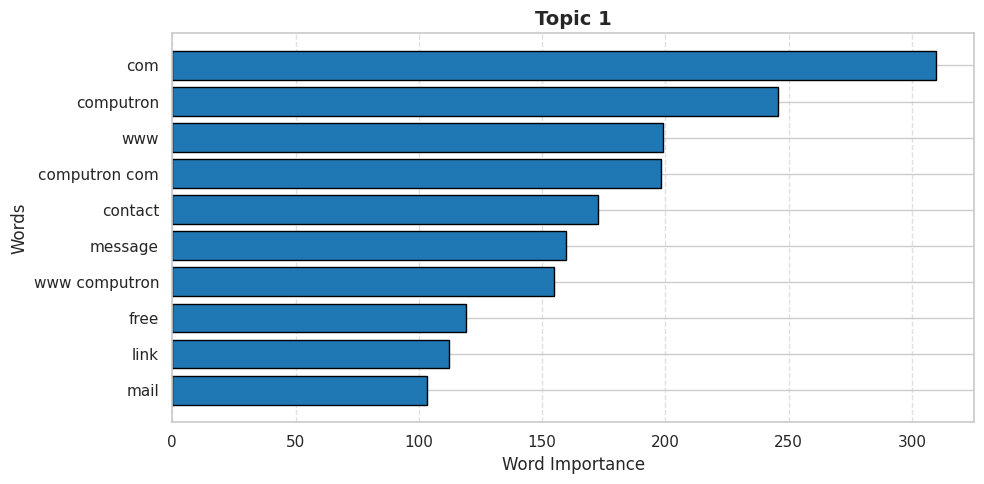

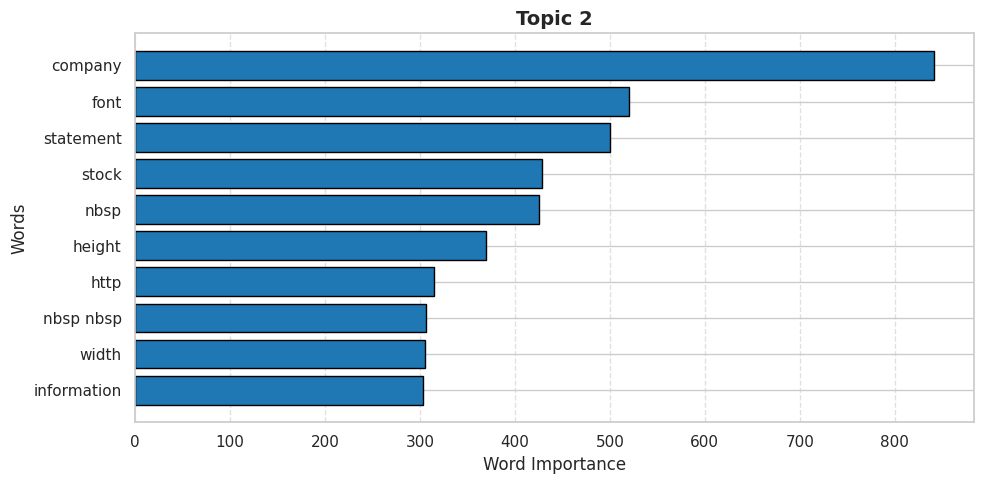

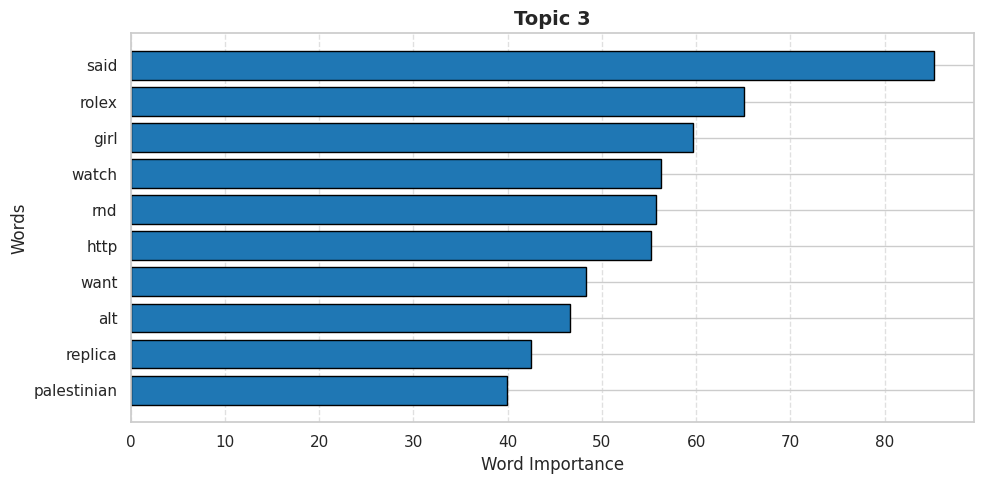

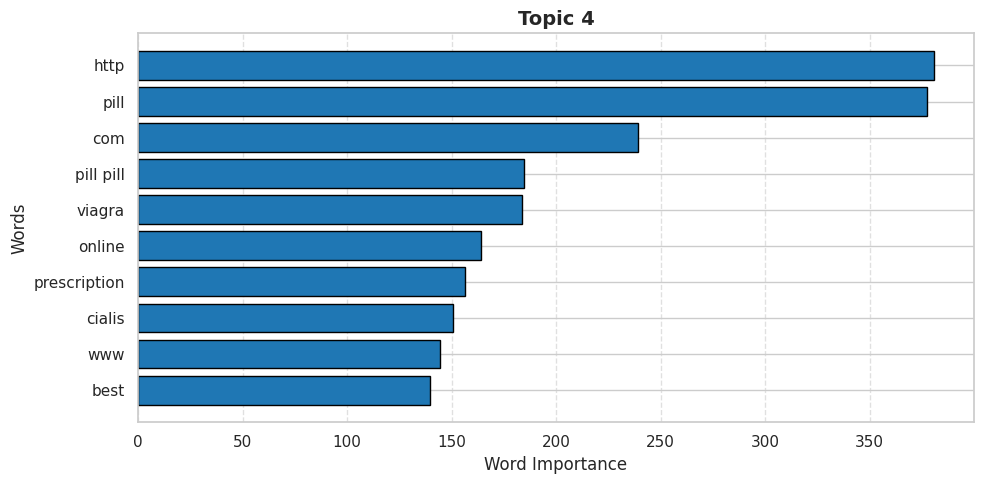

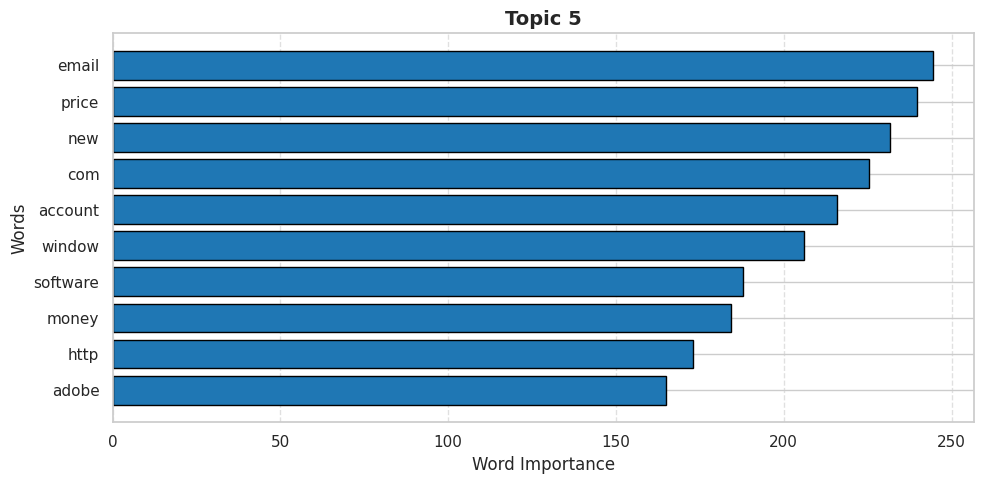

In [ ]:
# 11 - FUNCTION TO DISPLAY TOPICS
def display_topics_bar(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        # Get indices of the top words in this topic (sorted by importance)
        top_indices = topic.argsort()[:-no_top_words - 1:-1]

        # Extract corresponding words
        top_words = [feature_names[i] for i in top_indices]

        # Get importance values for these words
        top_values = topic[top_indices]

        # Create a horizontal bar chart
        plt.figure(figsize=(10, 5))  # Bigger figure for clarity
        plt.barh(top_words, top_values, color='#1f77b4', edgecolor='black')  # Clearer color & edges
        plt.gca().invert_yaxis()  # Highest values on top
        plt.title(f"Topic {topic_idx + 1}", fontsize=14, fontweight='bold')
        plt.xlabel("Word Importance", fontsize=12)
        plt.ylabel("Words", fontsize=12)
        plt.grid(axis='x', linestyle='--', alpha=0.6)  # Light grid for readability
        plt.tight_layout()
        plt.show()

# Display main topics for LDA model
print("\n📌 MAIN TOPICS FOUND WITH LDA:\n")
display_topics_bar(lda_model, vectorizer.get_feature_names_out(), 10)

##**11 - FUNCTION TO DISPLAY TOPICS:**
This code defines and uses a function to visualize the topics identified by the LDA model in a bar chart format.
The display_topics_bar function iterates over each topic in the model and:

1. Identifies the most representative words for the topic by sorting them based on their importance (weight in the LDA distribution);

2. Retrieves the corresponding terms and importance values for these top words;

3. Generates a horizontal bar chart with an optimized size for readability, a clear blue color with black edges, and a light horizontal grid for easier comparison;

4. Inverts the vertical axis so that the most important words appear at the top;

5. Adds descriptive titles and axis labels with larger, more readable fonts, and applies a compact layout to prevent overlap.

Finally, the function is called to display the top 10 most important terms for each topic discovered by the LDA model.
This visual representation makes it easier to quickly interpret the central themes of each topic, which can later be manually labeled based on their semantic meaning.


📌 MAIN TOPICS FOUND WITH NMF:



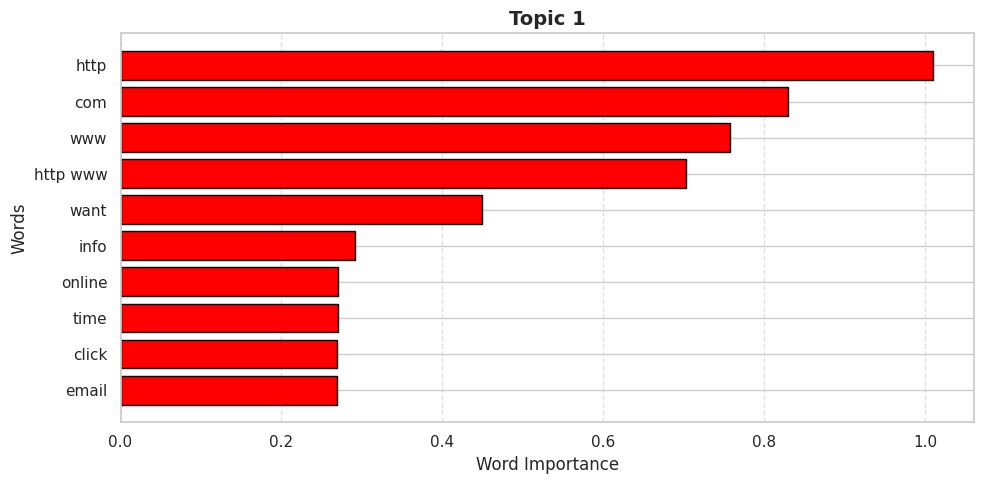

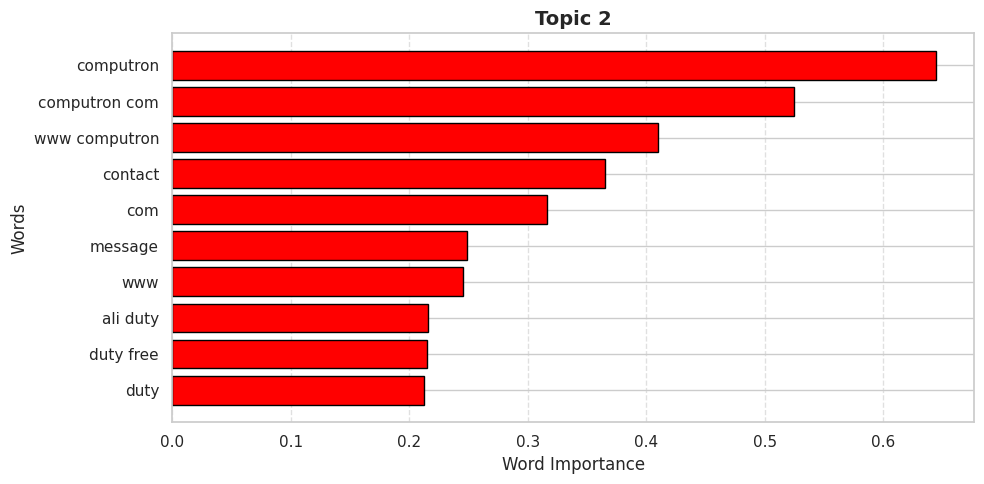

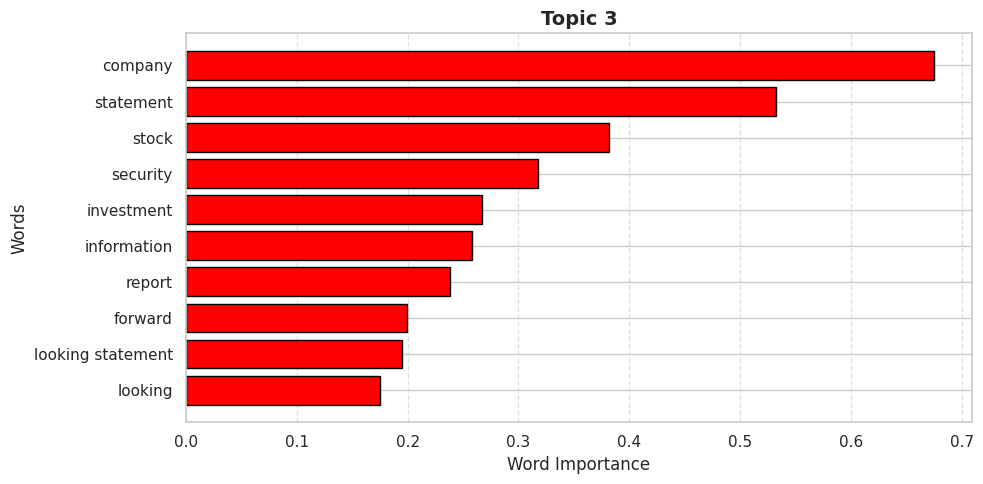

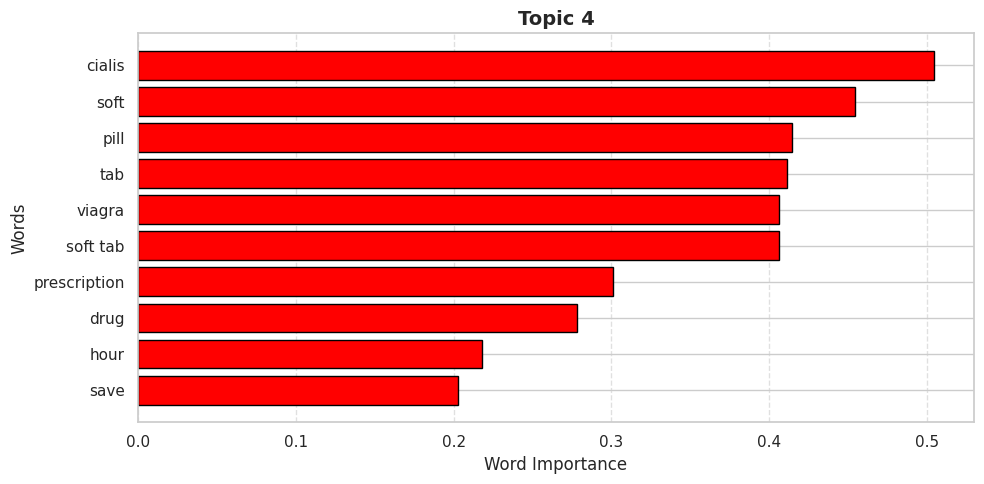

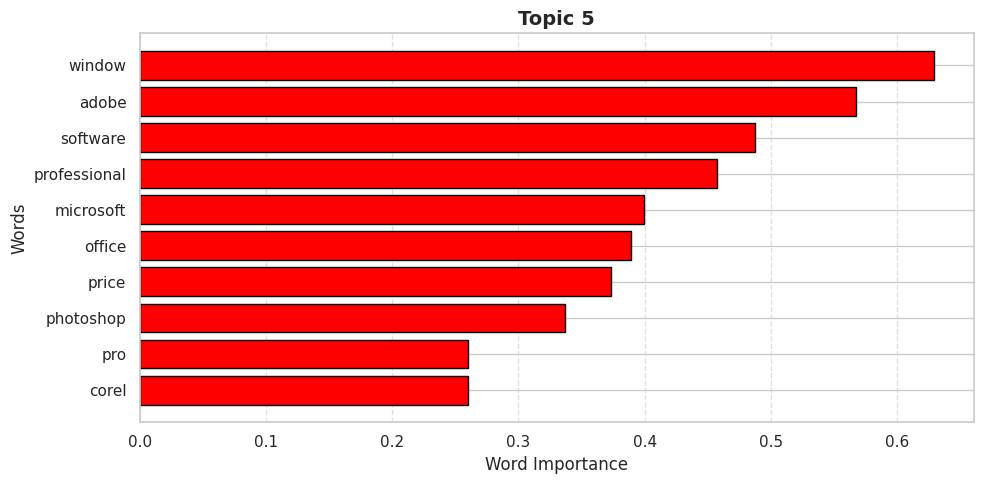

In [ ]:
# Vectorize spam text using TF-IDF (captures term importance and frequency)
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.85,           # Ignore very frequent terms
    min_df=5,              # Ignore very rare terms
    stop_words='english',  # Remove common English stopwords
    ngram_range=(1, 2)     # Use unigrams and bigrams
)

# Transform the cleaned spam text into a TF-IDF matrix
X_tfidf = tfidf_vectorizer.fit_transform(spam_df["clean_text"])

# Initialize NMF model for topic extraction
nmf_model = NMF(
    n_components=5,   # Number of topics to extract
    random_state=42   # Reproducibility
)

# Fit NMF model to TF-IDF features
nmf_model.fit(X_tfidf)

# Updated display function with red bars
def display_topics_bar_red(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[:-no_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_indices]
        top_values = topic[top_indices]

        plt.figure(figsize=(10, 5))
        plt.barh(top_words, top_values, color='red', edgecolor='black')
        plt.gca().invert_yaxis()
        plt.title(f"Topic {topic_idx + 1}", fontsize=14, fontweight='bold')
        plt.xlabel("Word Importance", fontsize=12)
        plt.ylabel("Words", fontsize=12)
        plt.grid(axis='x', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

# Display topics found with NMF
print("\n📌 MAIN TOPICS FOUND WITH NMF:\n")
display_topics_bar_red(nmf_model, tfidf_vectorizer.get_feature_names_out(), 10)

This code applies Non-negative Matrix Factorization (NMF) to discover the main topics in spam emails:

- Text representation:

  - Uses TF-IDF vectorization to convert text into numerical features;

  - Considers unigrams and bigrams (single words and word pairs);

  - Filters out very common or very rare terms to reduce noise.

- Topic extraction:

  - Applies NMF to decompose the term-document matrix into 5 latent topics;

  - Each topic is defined by a set of significant terms;

- Visualization:

  - The top 10 words per topic are displayed using a horizontal bar chart;

  - Facilitates interpretation and labeling of each topic.

- Comparison with LDA:

  - LDA is probabilistic, while NMF is a matrix factorization method;
  
  - NMF often produces more interpretable and sharper topics when applied to TF-IDF data.

In [ ]:
## PHASE 3: SEMANTIC DISTANCE BETWEEN TOPICS
# 12.a - NORMALIZE TOPIC VECTORS
def normalize_rows(mat, norm='l1'):
    if norm == 'l1':
        row_sums = mat.sum(axis=1, keepdims=True)  # Sum each row's values
        row_sums[row_sums == 0] = 1.0              # Avoid division by zero
        return mat / row_sums                      # Divide each element by row sum
    elif norm == 'l2':
        norms = np.linalg.norm(mat, axis=1, keepdims=True)  # Compute L2 norm for each row
        norms[norms == 0] = 1.0                            # Avoid division by zero
        return mat / norms                                 # Normalize each row by its L2 norm
    else:
        raise ValueError("norm must be 'l1' or 'l2'")       # Error for unsupported normalization type

##**12.a - NORMALIZE TOPIC VECTORS:**
This helper function ensures that each topic vector is normalized before similarity or distance calculations:

- With L1 normalization, the elements in each row sum to 1, making the row interpretable as a probability distribution (ideal for LDA topic-word distributions);

- With L2 normalization, each row has a length of 1 in Euclidean space, useful for cosine similarity calculations;

- Division-by-zero cases are handled to avoid runtime errors;

- This normalization is essential because it puts topic vectors on a comparable scale, preventing distortions in semantic distance computation.

In [ ]:
# 12.b - Jensen-Shannon distance
def jensen_shannon_distance(p, q, base=2):
    # Convert inputs to float numpy arrays
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)

    # Normalize to ensure they sum to 1 (avoid division errors)
    p = p / (p.sum() + 1e-12)
    q = q / (q.sum() + 1e-12)

    # Compute the average distribution
    m = 0.5 * (p + q)

    # Calculate Kullback-Leibler divergence between p and m, and q and m
    # Add a small epsilon to avoid log(0)
    kl_pm = entropy(p, m, base=base)
    kl_qm = entropy(q, m, base=base)

    # Jensen-Shannon divergence is the average of the two KL divergences
    jsd = 0.5 * (kl_pm + kl_qm)

    # Jensen-Shannon distance = sqrt(JSD), ensures range [0, 1]
    return np.sqrt(jsd)

##**12.b - Jensen-Shannon distance:**
This function computes the Jensen–Shannon distance (JSD), a symmetric and bounded measure of similarity between two probability distributions.

- It first ensures that the input vectors p and q are valid probability distributions (non-negative and summing to 1);

- It then computes the average distribution m between them;

- The Kullback–Leibler divergence (KL) is calculated between each distribution and m;

- The Jensen–Shannon divergence is the average of these KL divergences;

- Taking the square root transforms the divergence into a distance metric in the range [0, 1], where:

  - 0 means the topics are identical;
  
  - 1 means the topics are maximally different.

In [ ]:
# 12.c - Compute distance matrices and visualizations
def topic_distance_analysis(model, feature_names, model_name="LDA", top_n_words=15,
                            normalize='l1', dist_metric='cosine'):
    # 1) Extract topic-term matrix from model
    components = model.components_.copy()  # shape: (n_topics, n_terms)
    n_topics = components.shape[0]

    # 2) Normalize topic vectors (probability or unit length)
    normed = normalize_rows(components, norm=normalize)

    # 3) Compute topic-to-topic distance matrix
    if dist_metric == 'cosine':
        # Cosine similarity in [0,1]; distance = 1 - similarity
        sim = cosine_similarity(normed)  # topics x topics
        dist = 1.0 - sim
    elif dist_metric == 'js':
        # Compute Jensen-Shannon distance pairwise
        dist = np.zeros((n_topics, n_topics))
        for i in range(n_topics):
            for j in range(n_topics):
                dist[i, j] = jensen_shannon_distance(normed[i], normed[j])
    else:
        raise ValueError("dist_metric must be 'cosine' or 'js'")

    # 4) Print top words for each topic (quick inspection)
    print(f"\n--- {model_name} : Top {top_n_words} words per topic ---")
    for t in range(n_topics):
        top_idx = components[t].argsort()[:-top_n_words-1:-1]
        top_terms = [feature_names[i] for i in top_idx]
        print(f"Topic {t+1}: {', '.join(top_terms)}")

    # 5) Create heatmap with hierarchical clustering
    condensed = squareform(dist, checks=False)  # Convert to condensed form
    Z = linkage(condensed, method='average')    # Hierarchical clustering
    dendro = dendrogram(Z, no_plot=True)        # Get clustering order
    order = dendro['leaves']                    # New order of topics

    # Reorder distance matrix for visualization
    dist_ordered = dist[np.ix_(order, order)]
    topic_labels = [f"T{idx+1}" for idx in order]

    plt.figure(figsize=(8, 6))
    sns.heatmap(dist_ordered, xticklabels=topic_labels, yticklabels=topic_labels,
                cmap='Reds' if dist_metric=='cosine' else 'viridis',
                annot=True, fmt=".2f", square=True, cbar_kws={'label': 'Distance'})
    plt.title(f"{model_name} Topic Distance Matrix ({'1-cosine' if dist_metric=='cosine' else 'Jensen-Shannon'})")
    plt.tight_layout()
    plt.show()

    # 6) Visualize topic relationships with MDS projection
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    coords = mds.fit_transform(dist)  # 2D coordinates of topics
    plt.figure(figsize=(8, 6))
    palette = sns.color_palette("Reds", n_topics) if dist_metric=='cosine' else sns.color_palette("viridis", n_topics)
    for i, (x, y) in enumerate(coords):
        plt.scatter(x, y, s=200, color=palette[i], edgecolor='k', alpha=0.9)
        plt.text(x, y, f" T{i+1}", fontsize=12, va='center', ha='left', fontweight='bold')
    plt.title(f"{model_name} Topics MDS Projection (distance-based)")
    plt.xlabel("MDS dim 1")
    plt.ylabel("MDS dim 2")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 7) Return all relevant results for further analysis
    return {
        'components': components,                # Original topic-term matrix
        'normed': normed,                         # Normalized topic vectors
        'distance_matrix': dist,                  # Distance matrix
        'ordered_distance_matrix': dist_ordered,  # Reordered distance matrix
        'order': order,                           # Topic order from clustering
        'mds_coords': coords                      # 2D topic coordinates
    }

##**12.c - Compute distance matrices and visualizations:**
This function performs a complete semantic distance analysis between topics produced by a topic model (LDA, NMF, etc.):

1. Extracts topic vectors from the model’s components_;

2. Normalizes them to ensure comparability;

3. Computes pairwise distances between topics using either cosine distance or Jensen–Shannon distance;

4. Prints top words for each topic for easy interpretation;

5. Generates a heatmap of topic distances with hierarchical clustering to group similar topics;

6. Projects topics into 2D space using MDS to visualize their relationships;

7. Returns all computed data so it can be reused for further analysis.


--- LDA : Top 10 words per topic ---
Topic 1: com, computron, www, computron com, contact, message, www computron, free, link, mail
Topic 2: company, font, statement, stock, nbsp, height, http, nbsp nbsp, width, information
Topic 3: said, rolex, girl, watch, rnd, http, want, alt, replica, palestinian
Topic 4: http, pill, com, pill pill, viagra, online, prescription, cialis, www, best
Topic 5: email, price, new, com, account, window, software, money, http, adobe


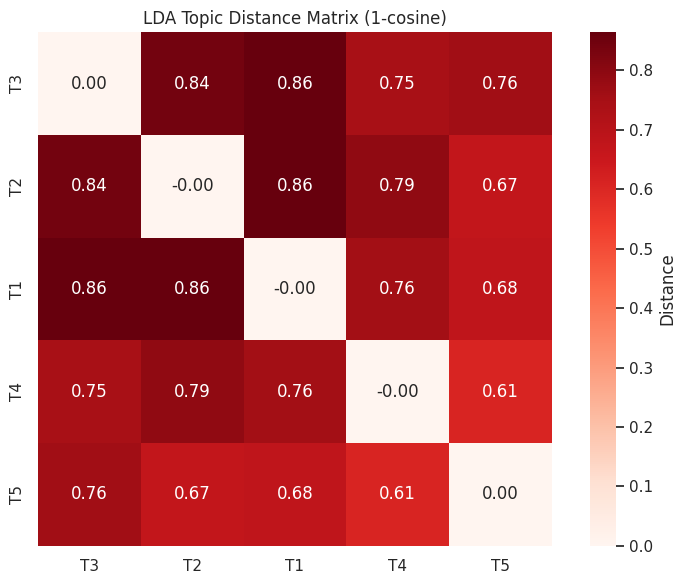

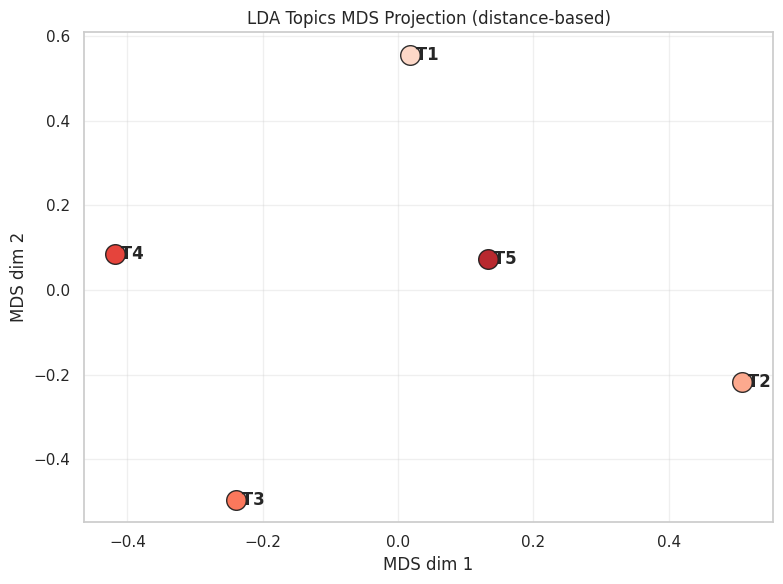

In [ ]:
# 13.a - EXAMPLE USAGE FOR LDA
# Run topic distance analysis on an LDA model
# Using L1 normalization because LDA components represent probability distributions
# (topic-word probabilities or counts that sum to 1 per topic)
lda_results = topic_distance_analysis(
    model=lda_model,                                # Trained LDA model
    feature_names=vectorizer.get_feature_names_out(), # Vocabulary terms from the vectorizer
    model_name="LDA",                               # Label used in plots and printouts
    top_n_words=10,                                 # Show top 10 words for each topic
    normalize='l1',                                 # Normalize topic-word vectors with L1 norm
    dist_metric='cosine'                            # Use cosine distance (1 - cosine similarity)
    # Change to 'js' to use Jensen–Shannon distance
)

##**13.a - EXAMPLE USAGE FOR LDA:**
This code demonstrates how to run the topic_distance_analysis function on an LDA model.

- L1 normalization is chosen because LDA’s topic-word matrix naturally represents probability distributions;

- The vocabulary is obtained from the vectorizer so top words can be displayed;

- The function computes topic-to-topic distances, visualizes them as a heatmap and MDS plot, and prints the top 10 words per topic;

- The distance metric is set to cosine distance, but Jensen–Shannon distance can be used by changing the dist_metric parameter.


--- NMF : Top 10 words per topic ---
Topic 1: http, com, www, http www, want, info, online, time, click, email
Topic 2: computron, computron com, www computron, contact, com, message, www, ali duty, duty free, duty
Topic 3: company, statement, stock, security, investment, information, report, forward, looking statement, looking
Topic 4: cialis, soft, pill, tab, viagra, soft tab, prescription, drug, hour, save
Topic 5: window, adobe, software, professional, microsoft, office, price, photoshop, pro, corel


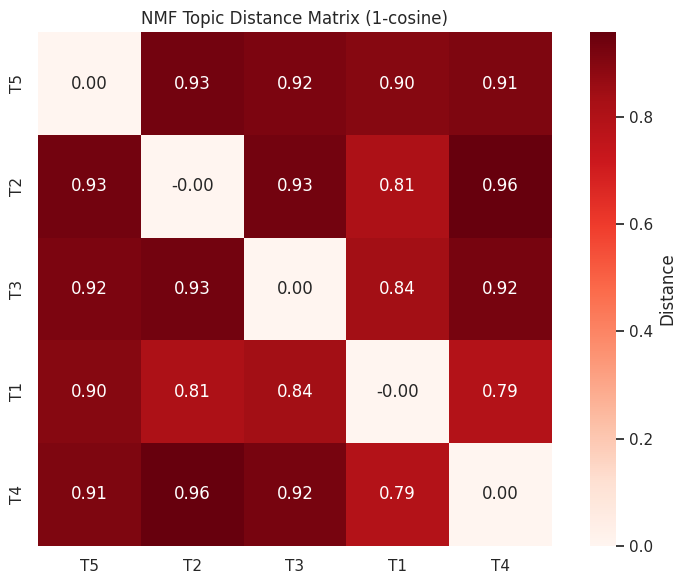

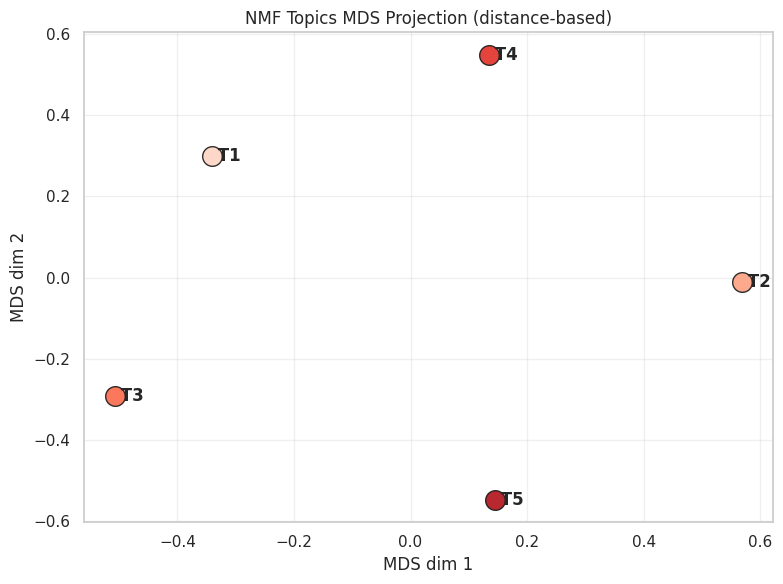

In [ ]:
# 13.b - For NMF (L2 or L1 both reasonable; TF-IDF-based components are weights)
# Run topic distance analysis on the trained NMF model
nmf_results = topic_distance_analysis(
    model=nmf_model,                                   # Trained NMF model
    feature_names=tfidf_vectorizer.get_feature_names_out(),  # Vocabulary from TF-IDF vectorizer
    model_name="NMF",                                  # Label used in output and plots
    top_n_words=10,                                    # Display top 10 words per topic
    normalize='l2',                                    # L2 normalization often works better for NMF weights
    dist_metric='cosine'                               # Use cosine distance to measure topic dissimilarity
    # Can change to 'js' for Jensen–Shannon distance if desired
)

##**13.b - For NMF (L2 or L1 both reasonable; TF-IDF-based components are weights):**
This code applies the topic distance analysis to the NMF model trained on TF-IDF features:

- It uses L2 normalization, which is often more appropriate for NMF because the components are non-probabilistic weights rather than probability distributions;

- The vocabulary comes from the TF-IDF vectorizer so the top words for each topic can be identified;

- The output includes:

 - Top 10 words for each topic;

 - Heatmap showing topic distances;

 - MDS 2D plot for a spatial view of topic separation.

- The distance metric is cosine distance, but Jensen–Shannon distance can also be tested for a probabilistic perspective.

In [ ]:
## PHASE 4: EXTRACT INFORMATION ABOUT THE ORGANIZATIONS MENTIONED FROM NON-SPAM EMAILS
# 14 - FILTERING OF NON-SPAM EMAILS
# Select only emails labeled as 'ham' (non-spam) from the original dataframe
ham_df = df[df['label'] == 'ham'].copy().reset_index(drop=True)

# Create a new column 'orig_text_for_ner' with the original email text as strings
# This preserves case, punctuation, and context, which are important for Named Entity Recognition
ham_df['orig_text_for_ner'] = ham_df['text'].astype(str)

##**14 - FILTERING OF NON-SPAM EMAILS:**
This code filters the dataset to focus on non-spam emails:

- Filtering:

  - Keeps only emails labeled as “ham” (non-spam);

  - Creates a new dataframe ham_df for further analysis.

- NER preparation:

  - Stores the original email text in a new column orig_text_for_ner;

  - Preserves case, punctuation, and formatting, which are crucial for accurate Named Entity Recognition.

- Purpose:

  - Ensures that NER can extract entities like organizations or names accurately from the unaltered text.

In [ ]:
# 15 - TEXT CLEANING FUNCTION
# Define a set of valid acronyms to preserve during cleaning
VALID_ACRONYMS = {"UN", "IBM", "EU", "USA", "UK"}

def clean_email_text(text):
    # Remove all lines starting with '>' which typically indicate quoted reply lines
    text = re.sub(r"(?m)^>.*$", "", text)

    # Remove common email signatures or phrases like "Best regards", "Sent from my ...", "Cheers", "Thanks,"
    # Case-insensitive and removes from these phrases to the end of the text
    text = re.sub(r"(?i)(best regards|sent from my .*|cheers|thanks,).*", "", text)

    # Replace line breaks and surrounding whitespace with a single space to normalize text
    text = re.sub(r"\s*\n\s*", " ", text)

    # Remove leading and trailing whitespace from the cleaned text
    return text.strip()

##**15 - TEXT CLEANING FUNCTION:**
This function cleans email text to improve NER quality:

- Removes quoted reply lines:

  - Lines starting with > are eliminated to avoid including previous email threads.

- Strips common signatures and polite phrases:

  - Examples include: “Best regards”, “Thanks,” or “Sent from my …”.

- Normalizes line breaks:

  - Converts multiple line breaks and surrounding spaces into a single space for smoother text.

- Purpose:

  - Focuses on the main content of the email;
  
  - Reduces noise, making Named Entity Recognition (NER) more accurate and reliable.

In [ ]:
# 16 - LOAD NER MODEL
# List of NER models to attempt loading, from lightweight to larger/finer models
NER_MODELS = [
    "dslim/bert-base-NER",  # Lightweight baseline model, faster and smaller
    "dbmdz/bert-large-cased-finetuned-conll03-english"  # Larger model with cased text, potentially more accurate
]

def build_ner_pipeline():
    last_error = None
    for model_name in NER_MODELS:
        try:
            # Create a Hugging Face NER pipeline with aggregation of tokens into entities
            ner = pipeline("ner", model=model_name, aggregation_strategy="simple")
            print(f"Loaded NER model: {model_name}")
            return ner
        except Exception as e:
            # Print error and store it if loading fails
            print(f"Could not load {model_name}: {e}")
            last_error = e
    # Raise error if no model could be loaded
    raise RuntimeError(f"Failed to load any NER model. Last error: {last_error}")

# Initialize the NER pipeline by loading the first available model
ner_pipeline = build_ner_pipeline()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


Loaded NER model: dslim/bert-base-NER


##**16 - LOAD NER MODEL:**
This code builds a robust Named Entity Recognition (NER) pipeline:

- Tries multiple models in order:

  - Starts with a smaller, faster model for quick loading;

  - Falls back to a larger, more accurate model if needed.

- Builds a NER pipeline:

  - Uses token aggregation to detect complete named entities instead of fragmented tokens.

- Handles errors gracefully:

  - If a model fails to load, prints an error message and moves to the next one;

  - Raises a runtime error only if all models fail to load.

- Purpose:

  - Ensures a working NER model is available for downstream entity extraction tasks.

In [ ]:
# 17 - NORMALIZE EXTRACTED ORGANIZATION NAMES
def normalize_org(text):
    if not text or not isinstance(text, str):
        return ""  # Return empty string if input is None or not a string
    s = text.strip()  # Remove leading/trailing whitespace
    s = re.sub(r'^[^A-Za-z0-9]+|[^A-Za-z0-9]+$', '', s)  # Remove punctuation at start/end
    s = re.sub(r'\s+', ' ', s)  # Replace multiple spaces with a single space

    # Check if the string is an acronym (2-5 uppercase letters, ignoring dots)
    if re.fullmatch(r'[A-Z]{2,5}', s.replace('.', '')):
        # Only keep if acronym is in the allowed list; otherwise, discard
        return s.replace('.', '') if s.replace('.', '') in VALID_ACRONYMS else ""

    # For other cases, return title-cased string if length is at least 3 characters
    return s.title() if len(s) >= 3 else ""

##**17 - NORMALIZE EXTRACTED ORGANIZATION NAMES:**
This function normalizes organization names extracted by NER:

- Text cleaning:

  - Strips leading and trailing whitespace;

  - Removes punctuation from the edges;

  - Collapses multiple spaces into a single space.

- Acronym handling:

  - Checks if the text matches a valid acronym (e.g., "IBM", "UN") from a predefined list;

  - Keeps valid acronyms in uppercase and removes any dots.

- General name normalization:

  - Converts names to title case if they are at least 3 characters long;

  - Ignores very short or irrelevant tokens to reduce noise.

- Purpose:

  - Standardizes organization names for consistent aggregation;
  
  - Reduces false positives and improves the quality of downstream analysis.

In [ ]:
# 18 - EXTRACT ORG ENTITIES IN BATCHES
BATCH_SIZE = 16  # Number of emails processed per batch for efficiency

def extract_orgs_from_texts(texts, ner_pipe, batch_size=BATCH_SIZE):
    results = []
    # Iterate over texts in batches with progress bar
    for i in tqdm(range(0, len(texts), batch_size), desc="NER batches"):
        # Clean each email text in the batch before NER to remove noise
        batch = [clean_email_text(t) for t in texts[i: i+batch_size]]
        try:
            # Apply the NER pipeline to the whole batch
            preds = ner_pipe(batch)
        except Exception:
            # If batch processing fails, fallback to processing one by one
            preds = [ner_pipe(t) for t in batch]
        # Extract organization entities from predictions
        for doc_preds in preds:
            orgs = []
            for ent in doc_preds:
                # Get the entity label from possible keys depending on model output
                label = ent.get('entity_group') or ent.get('entity') or ent.get('label')
                if label == 'ORG':
                    org_text = ent.get('word') or ent.get('text')
                    org_text = normalize_org(org_text)  # Clean and standardize org name
                    if org_text:
                        orgs.append(org_text)
            results.append(sorted(set(orgs)))  # Keep unique orgs per email
    return results

# Extract organizations from all ham email texts using the NER pipeline
ham_df['organizations'] = extract_orgs_from_texts(
    ham_df['orig_text_for_ner'].tolist(), ner_pipeline, batch_size=BATCH_SIZE
)

NER batches:   0%|          | 0/230 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


##**18 - EXTRACT ORG ENTITIES IN BATCHES:**
This function extracts organization (ORG) entities from emails in batches:

- Batch processing:

  - Splits the list of email texts into smaller batches for faster and more memory-efficient processing;

  - Falls back to processing emails individually if the batch processing fails.

- Text cleaning:

  - Removes quoted reply lines and email signatures;

  - Normalizes line breaks and other noisy elements.

- NER extraction:

  - Runs a Hugging Face Named Entity Recognition (NER) pipeline on the cleaned text;

  - Selects only entities labeled as ORG (organizations).

- Normalization:

  - Cleans and standardizes extracted organization names using a dedicated normalization function;

  - Ensures consistency for later aggregation and analysis.

- Output:

  - Collects unique organizations per email;

  - Stores results in the dataframe for further processing.

- Purpose:

  - Efficiently and accurately extracts organization mentions from non-spam emails while maintaining clean and normalized data.

In [ ]:
# 19 - FUZZY MERGE SIMILAR NAMES
FUZZY_THRESHOLD = 85  # Similarity score threshold for merging organization names

def fuzzy_dedupe(names, threshold=FUZZY_THRESHOLD):
    # Remove duplicates while preserving order and ignoring empty strings
    names = list(dict.fromkeys([n for n in names if n]))
    canonical = []  # List of canonical (merged) organization names
    groups = {}     # Mapping of canonical name to list of similar variants
    for name in names:
        if not canonical:
            # Initialize with first name
            canonical.append(name)
            groups[name] = [name]
            continue
        # Find the closest match in canonical list using token sort ratio
        match, score, idx = process.extractOne(name, canonical, scorer=fuzz.token_sort_ratio)
        if match and score >= threshold:
            # If similar enough, group under matched canonical name
            groups[match].append(name)
        else:
            # Otherwise, create new canonical group
            canonical.append(name)
            groups[name] = [name]
    return canonical, groups

# Flatten all organization mentions from all emails into one list
all_orgs = [o for sublist in ham_df['organizations'] for o in sublist]

# Count occurrences of raw extracted organization names
org_counts = Counter(all_orgs)

# Use fuzzy deduplication to merge variants of organization names
canonical_list, merged_groups = fuzzy_dedupe(list(org_counts.keys()), threshold=FUZZY_THRESHOLD)

# Create a map from every variant to its canonical representative
canon_map = {variant: canon for canon, variants in merged_groups.items() for variant in variants}

# Recalculate counts, aggregating counts for all variants under their canonical name
canon_counts = defaultdict(int)
for org, cnt in org_counts.items():
    canon_counts[canon_map.get(org, org)] += cnt

# Convert the aggregated counts into a DataFrame sorted by count descending
canon_df = pd.DataFrame(
    sorted(canon_counts.items(), key=lambda x: x[1], reverse=True),
    columns=['organization', 'count']
)

##**19 - FUZZY MERGE SIMILAR NAMES:**
This code performs fuzzy deduplication and canonicalization of organization names:

- Problem addressed:

  - Multiple variations, abbreviations, or misspellings of the same organization can appear in the dataset;

  - Without normalization, counts and analyses would be noisy and misleading.

- Fuzzy matching:

  - Uses token sort ratio to compare organization names;

  - Merges similar names above a defined similarity threshold into a single canonical form.

- Grouping and aggregation:

  - Collects all variants under their canonical name;

  - Aggregates the mention counts for each canonical organization.

- Output:

  - Produces a clean, consolidated list of organizations with accurate frequencies;

  - Reduces noise and ensures meaningful statistics for downstream analysis and visualization.

- Purpose:

  - Standardizes organization names to improve clarity and reliability of insights from the data.

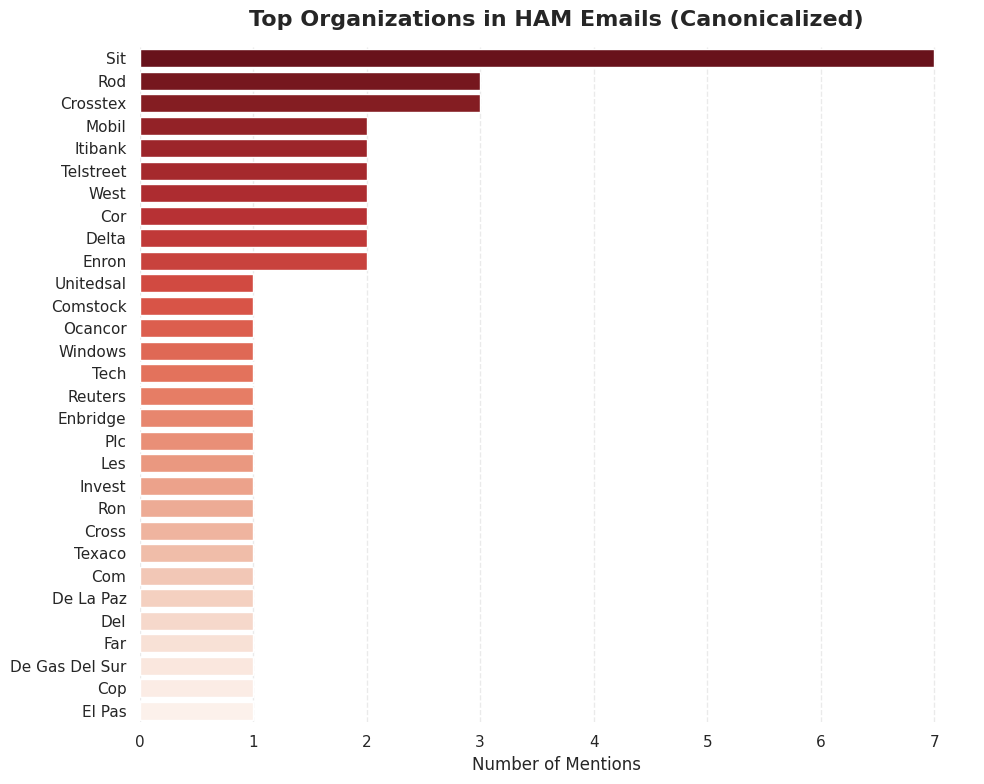

In [ ]:
# 20.a - PLOT TOP ORGANIZATIONS
TOP_K_ORGS = 30  # Number of top organizations to display

plt.figure(figsize=(10, 8))  # Set figure size for better readability

# Create a horizontal barplot showing the top organizations by mention count
ax = sns.barplot(
    data=canon_df.head(TOP_K_ORGS),  # Select top K organizations
    x='count',                       # X-axis: number of mentions
    y='organization',                # Y-axis: organization names
    hue='organization',              # Color bars by organization (distinct colors)
    palette='Reds_r',                # Color palette (red shades reversed)
    legend=False                    # Disable legend since hue equals y-axis labels
)

# Add title with font size, bold weight, and padding for spacing
plt.title("Top Organizations in HAM Emails (Canonicalized)", fontsize=16, fontweight='bold', pad=15)

# Label X-axis clearly, leave Y-axis label blank (organization names are self-explanatory)
plt.xlabel("Number of Mentions", fontsize=12)
plt.ylabel("")

# Remove left and bottom spines for a cleaner look
sns.despine(left=True, bottom=True)

# Add grid lines along the x-axis for easier value comparison, with light dashed style
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Adjust layout to avoid clipping labels/titles
plt.tight_layout()
plt.show()

##**20.a - PLOT TOP ORGANIZATIONS:**
This code generates a horizontal bar chart for the top 30 organizations:

- Purpose:

  - Visualize the most frequently mentioned organizations in a clean and interpretable way.

- Data:

  - Uses the canonicalized organization names with their aggregated counts;

  - Focuses on the top 30 organizations for clarity.

- Styling and aesthetics:

  - Horizontal bars for easy comparison;

  - Hue colors each bar distinctly according to the organization;

  - Legend disabled to reduce redundancy;

  - Reversed red palette (Reds_r) emphasizes higher counts with deeper shades;

  - Spines removed and subtle grid lines added for cleaner look;

  - Titles, labels, and layout are set for readability and presentation.

- Outcome:

  - Quickly communicates which organizations appear most frequently in the emails;
  
  - Enhances interpretability for reports or presentations.

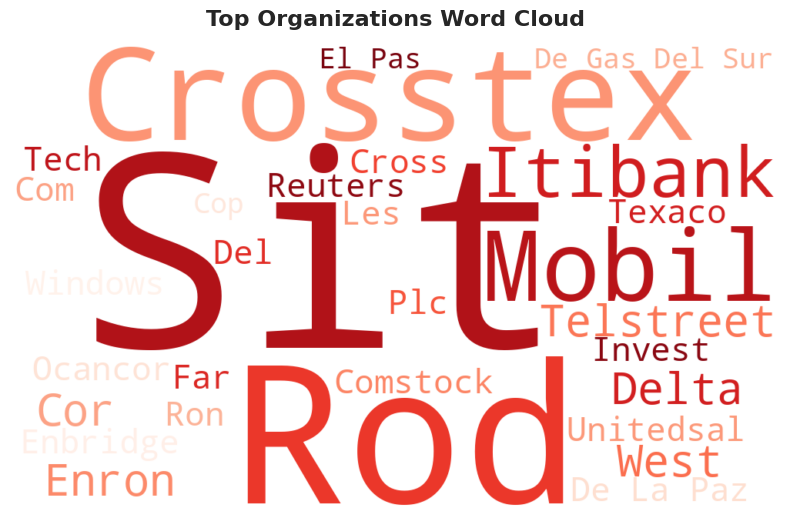

In [ ]:
# 20.b - BUILD A FREQUENCY DICTIONARY FOR WORD CLOUD
freq_dict = dict(canon_df.head(TOP_K_ORGS).values)  # Convert top organizations and counts to dictionary

# Generate a word cloud based on organization mention frequencies
wordcloud = WordCloud(
    width=1000,                 # Width of the word cloud image
    height=600,                 # Height of the word cloud image
    background_color='white',   # Set background to white for clarity
    colormap='Reds',            # Use a red color map to match previous plots
    prefer_horizontal=1.0       # Prefer horizontal word orientation for readability
).generate_from_frequencies(freq_dict)  # Generate word cloud from frequency dictionary

plt.figure(figsize=(12, 6))  # Set figure size
plt.imshow(wordcloud, interpolation='bilinear')  # Display the generated word cloud with smooth rendering
plt.axis('off')  # Hide axes for cleaner look
plt.title("Top Organizations Word Cloud", fontsize=16, fontweight='bold', pad=15)  # Add title with formatting
plt.show()  # Render the plot

##**20.b - BUILD A FREQUENCY DICTIONARY FOR WORD CLOUD:**
This code generates a word cloud for the top organizations:

- Purpose:

  - Visually represent the frequency of organization mentions in a compact, intuitive format;

  - Complement bar charts by showing relative prominence of entities.

- Data:

  - Uses the top organizations (e.g., top 30) and their mention counts;

  - Each organization’s size in the cloud corresponds to its frequency.

- Styling and aesthetics:

  - White background for clarity;

  - Red color palette consistent with other visualizations;

  - Horizontal orientation to improve readability;

  - Smooth layout ensures easy visual comparison of prominence.

- Outcome:

  - Quickly identifies the most mentioned organizations;
  
  - Provides an engaging and visually appealing summary of the data.

##**PROJECT CONCLUSIONS:**
The project successfully delivered a complete email analysis pipeline for ProfessionAI, focusing on spam detection and organization extraction:

- Spam Classification:

  - A Logistic Regression model accurately identifies spam emails;

  - Balanced training and TF-IDF features ensured reliable performance across classes.

- Spam Content Analysis:

  - Topic modeling (LDA and NMF) revealed the main themes in spam emails;

  - Semantic analysis quantified topic diversity, highlighting trends and recurring patterns.

- Non-Spam Email Insights:

  - Named Entity Recognition extracted organizations mentioned in legitimate emails;

  - Normalization and deduplication produced a clean, actionable list for business intelligence.

Impact for ProfessionAI:

- Improved spam filters reduce unwanted emails and optimize communication management;

- Insight into spam content and trends enhances cybersecurity strategies;

- Extraction of organization mentions from non-spam emails supports better business decision-making.

The solution provides accurate spam detection, meaningful content insights, and structured organization data, increasing communication security and delivering actionable business intelligence.